### Résolution du problème _Soft Support Vector Machine_ par Descente de Gradient et par Descente de Gradient Stochastique

Voir chapitre 15 du livre Understanding Machine Learning de S. Shalev-Shwartz et S. Ben-David

In [85]:
import numpy as np
import matplotlib.pyplot as plt

In [86]:
np.random.randint(4)

3

In [87]:
def hinge_loss(x):
    return max(0,1-x)

In [88]:
class Hyperplan:
    d=2
    def __init__(self,w=np.zeros(1),b=0):
        if self.d>=len(w):
            self.w=np.concatenate((w,np.zeros(self.d-len(w))))
        else:
            self.w=w[0:self.d]
        self.b=b
        
    def __repr__(self):
        return f"{self.__class__.__name__}({self.w,self.b})"
    
    def __call__(self, x):
        return np.dot(self.w,x)+self.b
    
    def __add__(self,other):
        return Hyperplan(self.w+other.w,self.b+other.b)
    
    def __sub__(self,other):
        return Hyperplan(self.w-other.w,self.b-other.b)
    
    def external_prod(self,a):
        return Hyperplan(self.w*a,self.b*a)
        
    def loss(self,x,y):
        return hinge_loss(y*self(x))
    
    def square(self):
        return np.dot(self.w,self.w)+self.b**2
    
    def risk(self,x,y,lambd):
        return lambd/2*self.square()+1/len(y)*sum([self.loss(xi,y[i]) for i,xi in enumerate(x)])
    
    def risk_vrai(self,x,y):
        return sum([np.sign(self(xx))!=y[i] for i,xx in enumerate(x)])/len(x)
    
    def gradient_loss(self,x,y,lambd):
        
        if y*self(x)<1:
            v1=lambd*self.w-y*x
            v2=lambd*self.b-y
        else:
            v1=lambd*self.w
            v2=lambd*self.b
        return Hyperplan(v1,v2)
    
    def gradient_risk(self,x,y,lambd):
        
        grad=Hyperplan()
        for i in range(len(y)):
            grad += self.gradient_loss(x[i],y[i],lambd)
        return grad.external_prod(1/len(y))
    
    def SGD(self,x,y,lambd,niter=1000,learning=0.1,averaging=1):
        
        i0=abs(niter-averaging)
        liste=[self]
        resultat=self
        for i in range(niter):
            it=np.random.randint(len(x))
            vt=liste[i].gradient_loss(x[it],y[it],lambd)
            liste.append(liste[i]-vt.external_prod(learning/(1+learning*lambd*(i+1))))
            mut=1/max(1,i-i0+1)
            resultat=resultat.external_prod(1-mut)+liste[-1].external_prod(mut)

        return resultat,liste
    
    def GD(self,x,y,lambd,niter=1000,learning=0.1,averaging=1):
        liste=[self]
        for i in range(niter):
            vt=liste[i].gradient_risk(x,y,lambd)
            liste.append(liste[i]-vt.external_prod(learning/(1+learning*lambd*(i+1))))
#            self=self-vt.external_prod(learning)
        resultat=liste[-1]
        return resultat,liste

In [89]:
h = Hyperplan([1,2])
h([0.5, 0.5])

1.5

In [90]:
d = 2
h1, h2 = Hyperplan([1,2], 1), Hyperplan([3,4], 2)
h1 + h2

Hyperplan((array([4., 6.]), 3))

In [91]:
h1 - h2

Hyperplan((array([-2., -2.]), -1))

In [92]:
h1.external_prod(2.0), h2.external_prod(3.0)

(Hyperplan((array([2., 4.]), 2.0)), Hyperplan((array([ 9., 12.]), 6.0)))

In [93]:
h1.loss( [0.1,0.2], 1), h2.loss( [0.1,0.2], -1)

(0, 4.1)

In [94]:
h1.square(), h2.square()

(6.0, 29.0)

In [95]:
class Polynomial:
    def __init__(self, weights=[0]):
        self.weights = np.array(weights)
        d=np.shape(weights)[0]
        self.void = np.zeros([d,d])
        
        for i in range(d):
            for j in range(d-i):
                self.void[i,j]=1
        self.weights=self.weights*self.void
        
    def __repr__(self):
        return f"{self.__class__.__name__}({self.weights})"
    
    @property
    def degree(self):
        return np.shape(self.weights)[0]-1
    
    def __call__(self, x):
        X1=np.transpose(np.array([[x[0]**exp for exp in range(self.degree+1)]]))
        X2=np.array([[x[1]**exp for exp in range(self.degree+1)]])
        return np.dot(X2,np.dot(self.weights,X1))[0,0]

In [96]:
d = 2
h1, h2 = Hyperplan([1,2], 1), Hyperplan([3,4], 2)
print(h1 + h2)
print(h1.square(), h2.square())
h1([1,2])

Hyperplan((array([4., 6.]), 3))
6.0 29.0


6.0

In [74]:
def affiche(x,y,h):
    m=len(x)
    yresult=np.array([np.sign(h(x[i])) for i in range(m)])
    plt.figure(1)
    plt.rcParams["figure.figsize"] = [20,10]
    fig,axs=plt.subplots(1,2, sharey=True)

    axs[0].scatter(x[:,0],x[:,1],c=y, cmap = plt.cm.Paired, edgecolor='k')
    axs[0].set_title('Données de test',fontsize=14)
    axs[0].set_aspect("equal")
    axs[1].scatter(x[:,0],x[:,1],c=yresult, cmap = plt.cm.Paired, edgecolor='k')
    axs[1].set_aspect("equal")


In [75]:
def affiche_risques(liste,x,y,lambd):
    risque=[l.risk(x,y,lambd) for l in liste]
    risque_vrai=[l.risk_vrai(x,y) for l in liste]
    plt.plot(risque)
    plt.plot(risque_vrai)    

In [76]:
# Les paramètres :
# dimension de l'espace des x
Hyperplan.d=2

# degré du polynôme de départ
deg=1

# on introduit ce petit pourcentage d'erreurs dans les données
seuil_erreur=0.

# taille de l'échantillon de données d'entraînement
m=100

# taille de l'échantillon de données de test 
mtest=1000

# bornes sur l'espace des données x
xmax=1.25
xmin=-1.25

# valeur de lambda pour le soft-SVM
lambd=1

# valeur du taux d'apprentissage initialement pour le soft-SVM
learning=0.1

# taille du stencil pour l'averaging dans la SGD
averaging=10

In [77]:
# fabrication des données
np.random.seed(1234)
w      = np.random.random((deg+1,deg+1))
w[0,0] = 0.0

In [78]:
pf = Polynomial(w)
x  = xmin + (xmax - xmin) * np.random.random((m,Hyperplan.d))
u  = np.random.rand(m)
y  = np.zeros(m)
y[ u >  seuil_erreur ] =   np.sign(np.array([pf(xx) for xx,uu in zip(x,u) if uu >   seuil_erreur]))
y[ u <= seuil_erreur ] = - np.sign(np.array([pf(xx) for xx,uu in zip(x,u) if uu <=  seuil_erreur]))

In [79]:
np.random.seed(5678)
xtest = xmin + (xmax - xmin) * np.random.random((mtest,Hyperplan.d))
ytest = np.sign(np.array(list(map(pf, xtest))))

In [80]:
# Résolution du problème soft-SVM
h = Hyperplan()
h,liste = h.SGD(x,y,lambd,200,learning,averaging)

<Figure size 1440x720 with 0 Axes>

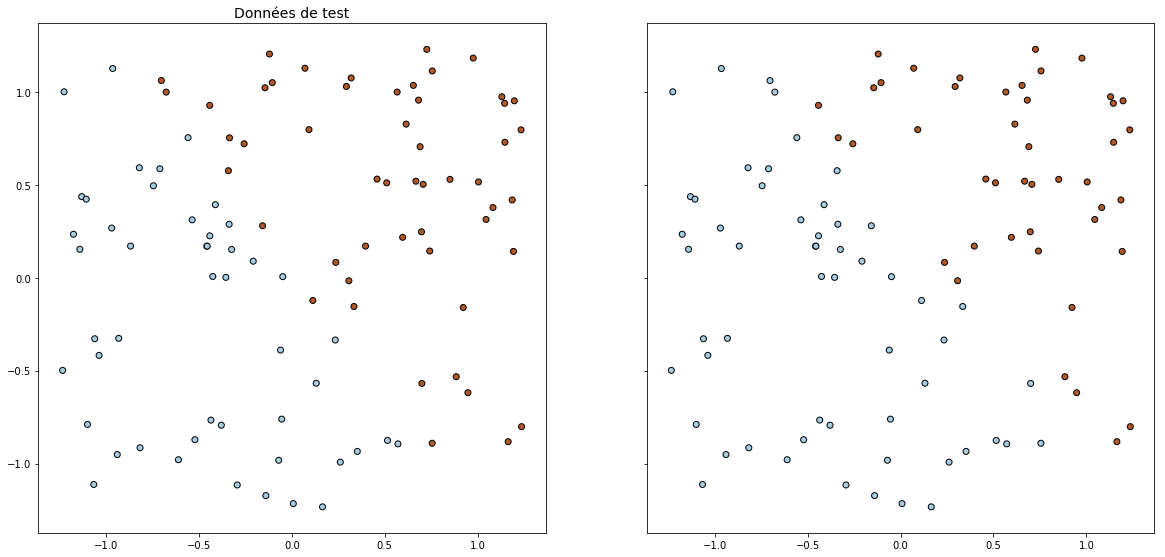

In [81]:
affiche(x,y,h)

<Figure size 1440x720 with 0 Axes>

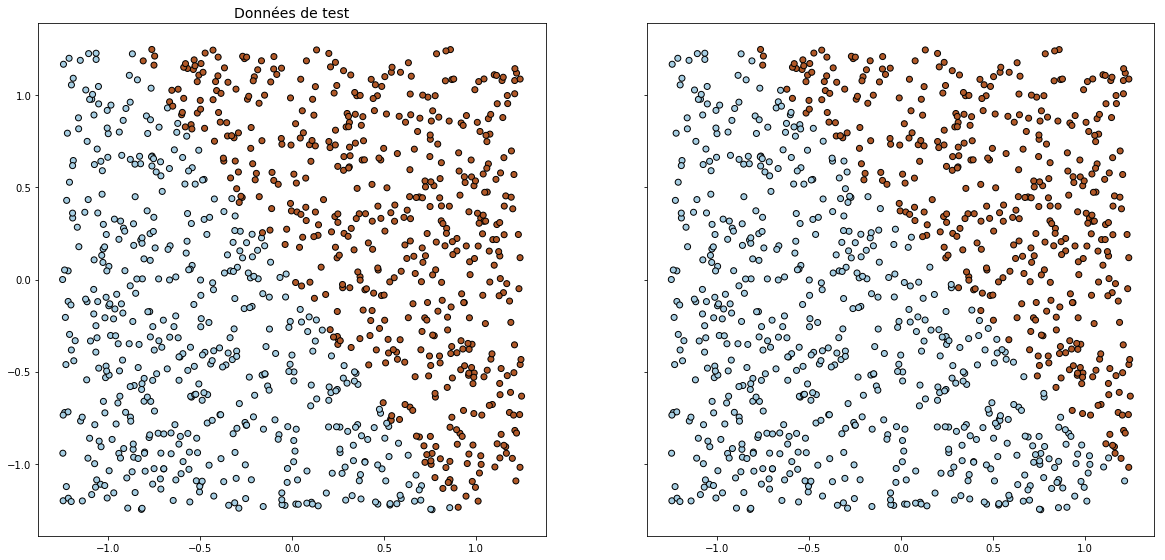

In [82]:
affiche(xtest,ytest,h)

In [83]:
from sklearn.metrics import accuracy_score

yresult=np.array([np.sign(h(xtest[i])) for i in range(mtest)])
accuracy_score(ytest, yresult)

0.892

In [84]:
affiche_risques(liste,xtest,ytest,lambd)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

## scikit-learn

0.923

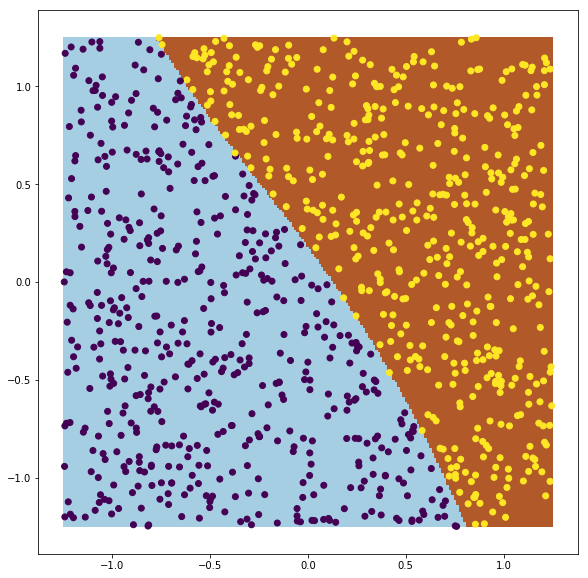

In [26]:
from sklearn.svm import SVC

clf = SVC(gamma="auto")
clf.fit(x, y)
ypred = clf.predict(xtest)
ax = plt.subplot(1,1,1)
ax.set_aspect("equal")
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(xmin, xmax, 200))
Z = clf.predict(np.column_stack([xx.ravel(),yy.ravel()]))
Z = Z.reshape(xx.shape)
ax.set_aspect('equal')
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(xtest[:,0],xtest[:,1],c=ypred)
yresult=np.array([np.sign(h(xtest[i])) for i in range(mtest)])
clf.score(xtest, yresult)